In [1]:
# =============================================================================
# Import modules
# =============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from itertools import compress
from sklearn.model_selection import GridSearchCV
import seaborn as sb
from scipy import stats
import os




In [2]:
# =============================================================================
# Load data
# =============================================================================
train_data = pd.read_csv("../input/Concrete_train.csv")
test_data = pd.read_csv("../input/Concrete_test.csv")
train_data = train_data.drop(["Id"], axis=1);
test_data = test_data.drop(["Id"], axis=1)

In [3]:
# =============================================================================
# Raw data inspection
# =============================================================================
train_data.describe()

,Cement,BlastFurnaceSlag,FlyAsh,Water,Superplasticizer,CoarseAggregate,FineAggregate,Age,ConcreteCompressiveStrength,MixtureMeasurement9,PlasticizerDensity,SSL9000,O2_purityscore,F192,Moisture,Concrete_m2,TysonScore
count,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000,723.000000
mean,284.630999,74.764495,52.215951,181.829375,6.114700,973.978163,790.870922,46.000000,36.166016,199.802213,99.993389,499.589212,9.978473,0.040150,181.236339,103398.155100,968.052129
std,108.660697,87.684342,63.993661,21.152681,6.044390,78.891866,381.698627,61.572604,16.830481,50.323038,1.032107,10.149096,14.675943,0.496042,29.599507,98715.601851,2095.825930
min,102.000000,0.000000,0.000000,121.750000,-1.350926,801.000000,594.000000,1.000000,2.331808,41.000000,97.103745,467.000000,-35.114485,-1.588352,73.712094,1.638346,-4993.282669
25%,192.750000,0.000000,0.000000,166.110000,0.000000,932.000000,726.600000,14.000000,23.869659,169.000000,99.299904,493.000000,-0.054723,-0.288082,160.739557,26565.573699,-537.711759
50%,277.000000,22.000000,0.000000,185.700000,6.000000,968.000000,778.450000,28.000000,35.076402,201.000000,99.975767,500.000000,10.282286,0.017783,180.983059,73526.060162,986.648416
75%,362.600000,145.000000,117.540000,192.000000,10.100000,1040.000000,822.100000,56.000000,46.317619,232.000000,100.666306,506.000000,20.193711,0.370001,200.167791,150735.687018,2434.362774
max,540.000000,359.400000,235.138388,247.000000,32.200000,1192.773588,9163.484392,365.000000,82.599225,396.000000,103.243093,531.000000,56.183212,1.926366,290.319251,477724.532223,6680.809041


In [4]:
train_data.isnull().sum() # Check for NaN in train set

Cement                         0
BlastFurnaceSlag               0
FlyAsh                         0
Water                          0
Superplasticizer               0
CoarseAggregate                0
FineAggregate                  0
Age                            0
ConcreteCompressiveStrength    0
MixtureMeasurement9            0
PlasticizerDensity             0
SSL9000                        0
O2_purityscore                 0
F192                           0
Moisture                       0
Concrete_m2                    0
TysonScore                     0
dtype: int64

In [5]:
test_data.isnull().sum() # Check for NaN in test set

Cement                 0
BlastFurnaceSlag       0
FlyAsh                 0
Water                  0
Superplasticizer       0
CoarseAggregate        0
FineAggregate          0
Age                    0
MixtureMeasurement9    0
PlasticizerDensity     0
SSL9000                0
O2_purityscore         0
F192                   0
Moisture               0
Concrete_m2            0
TysonScore             0
dtype: int64

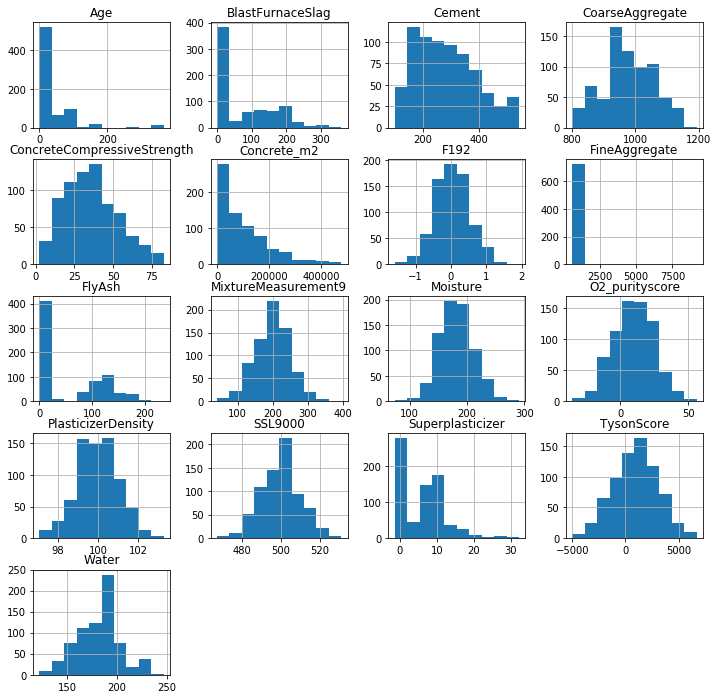

In [6]:
train_hist = train_data.hist(figsize=(12, 12)) # HISTOGRAM

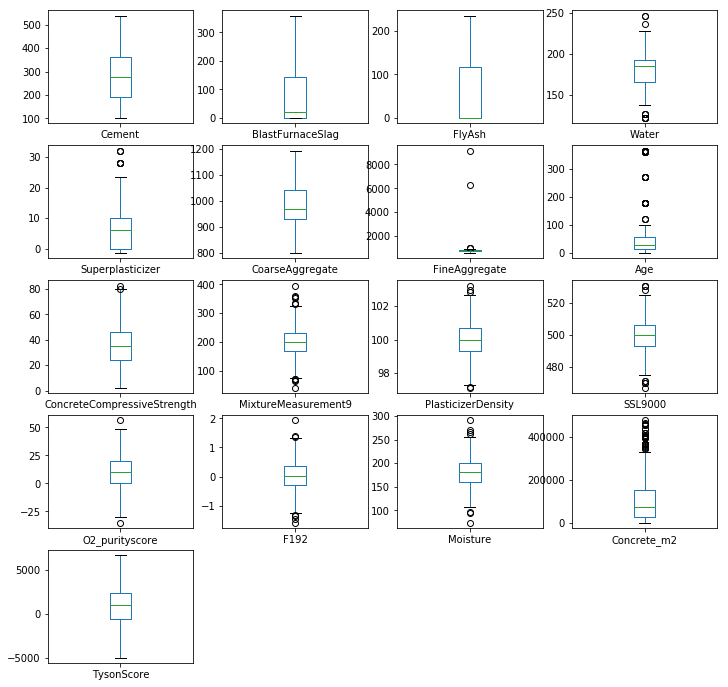

In [7]:
train_box = train_data.plot(kind="box", subplots=True, figsize=(12, 12), 
                           layout=(5,4), sharex=False, sharey=False) # BOXPLOT

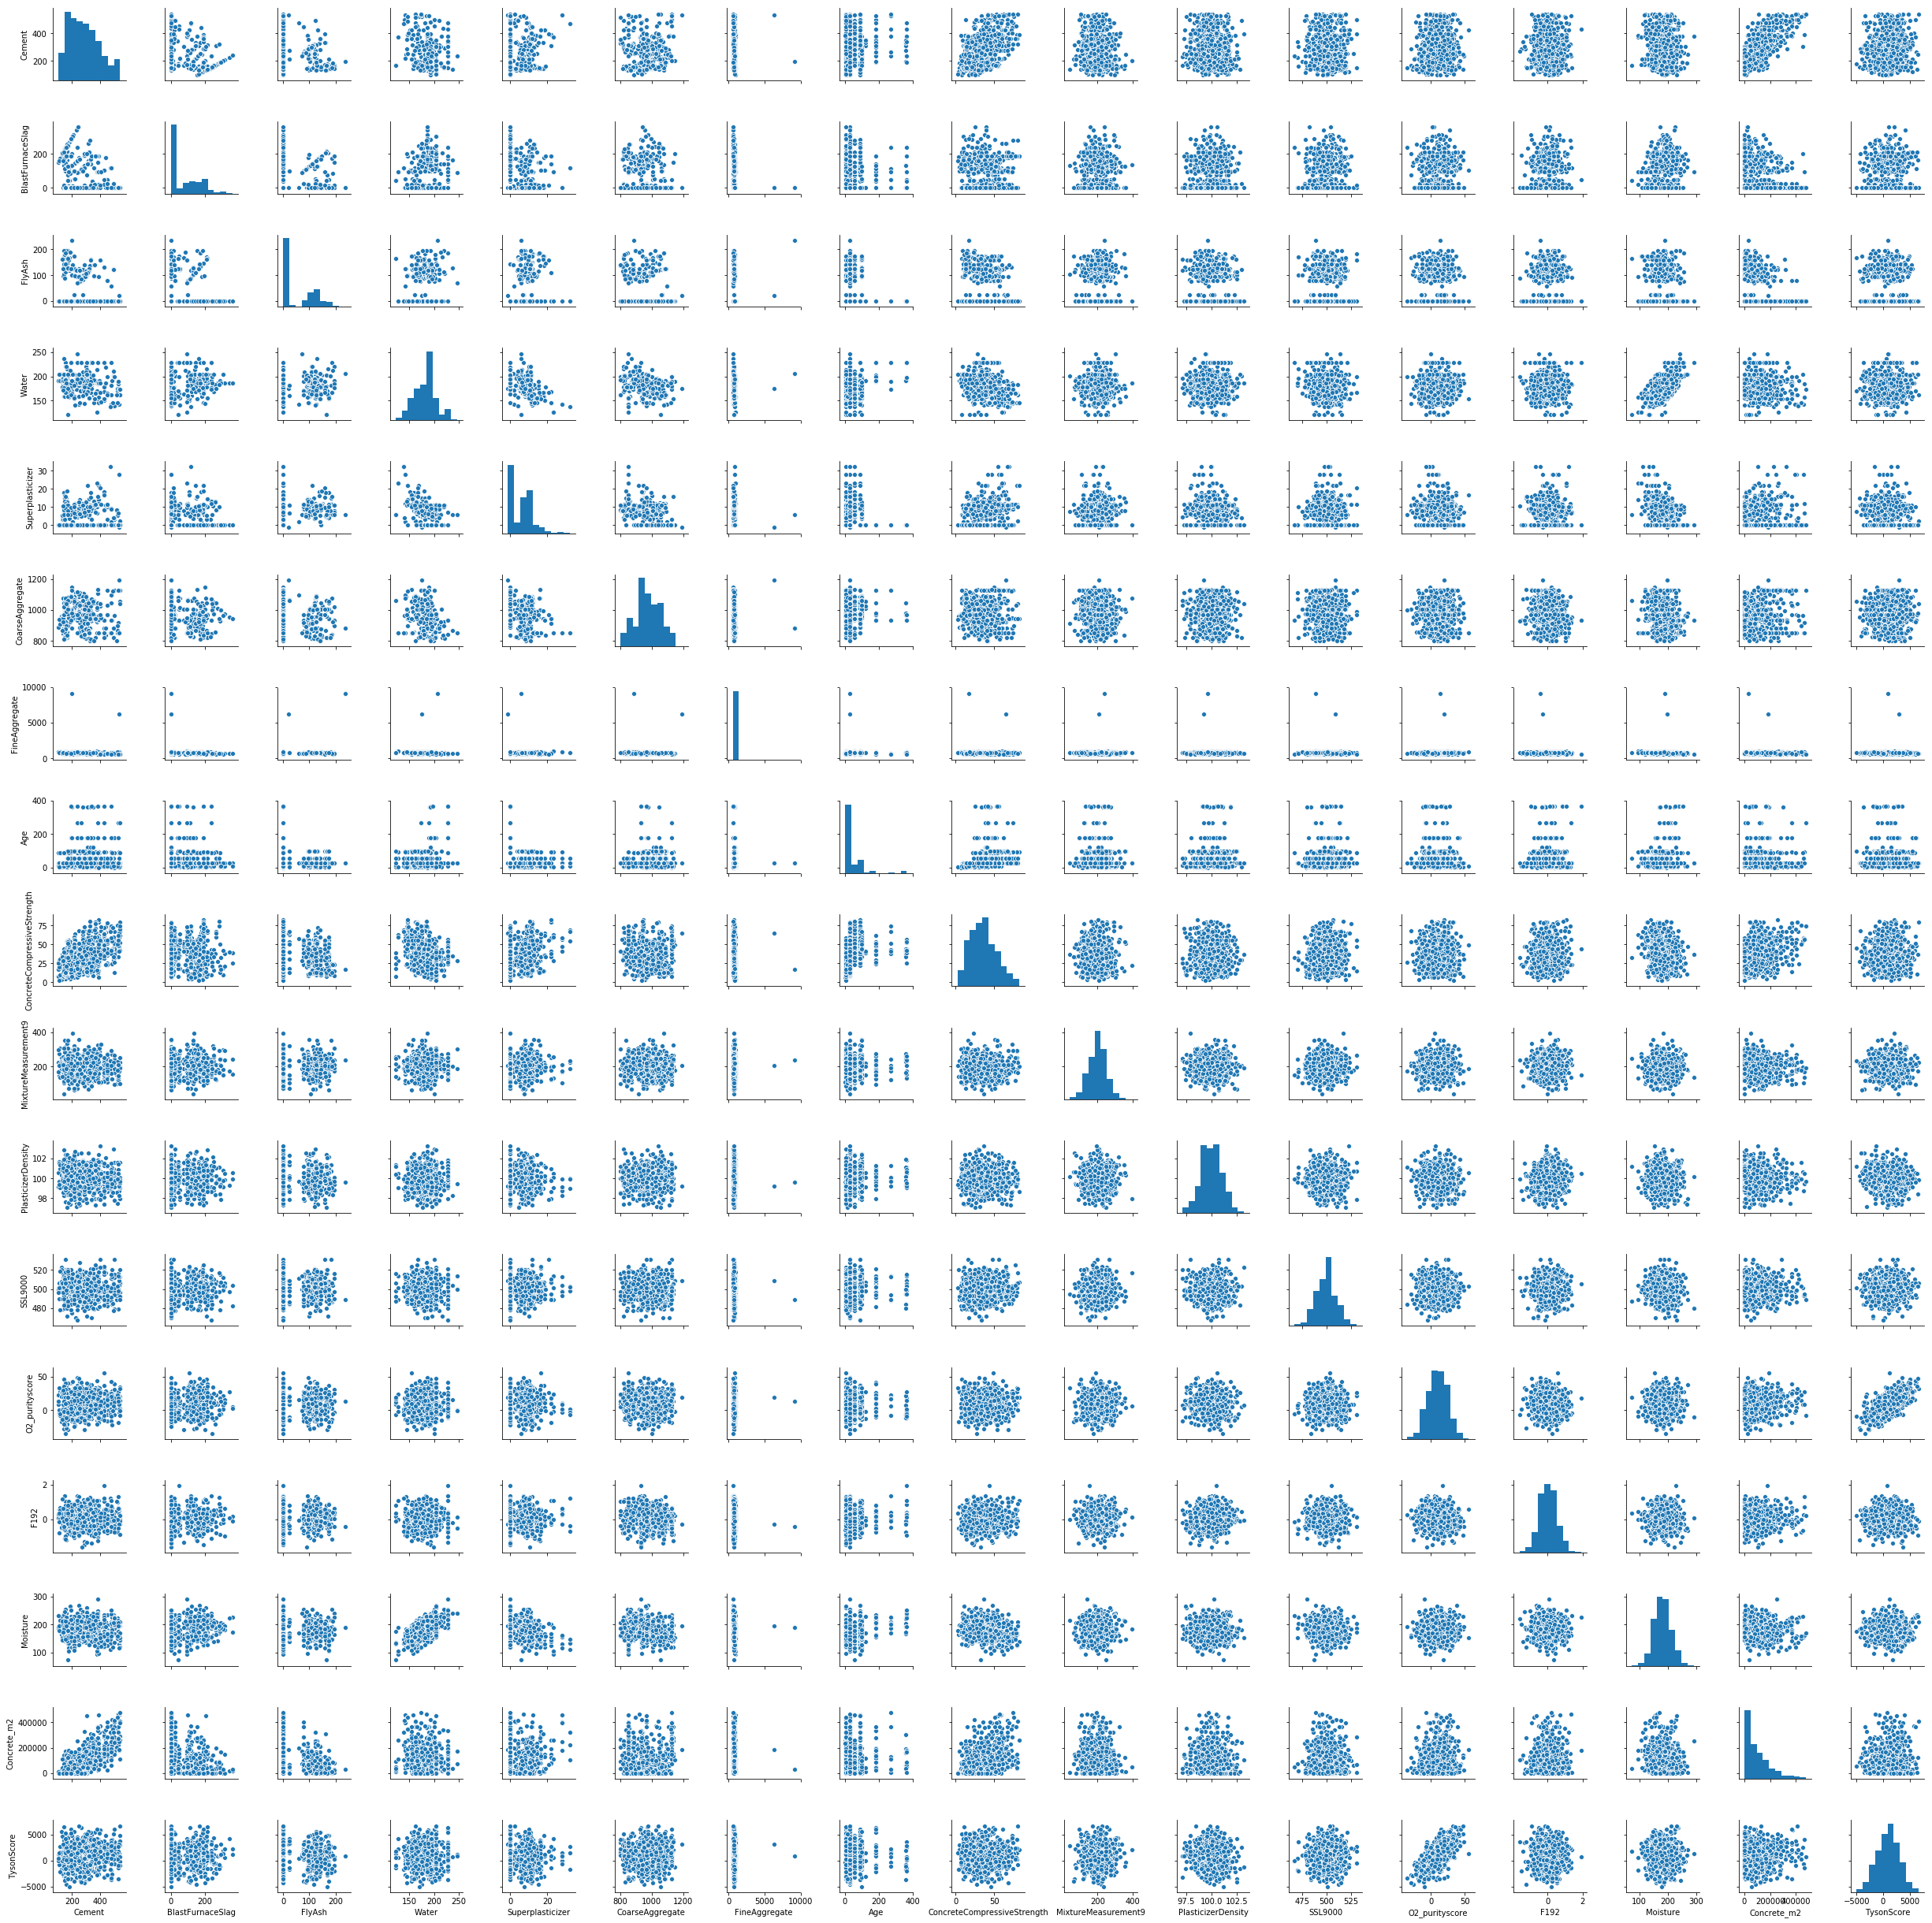

In [8]:
sns = sb.pairplot(train_data, height=2.0) # PAIRPLOT, IF YOU RIGHT CLICK AND CLICK VIEW IMAGE YOU CAN ZOOM AND SCROLL

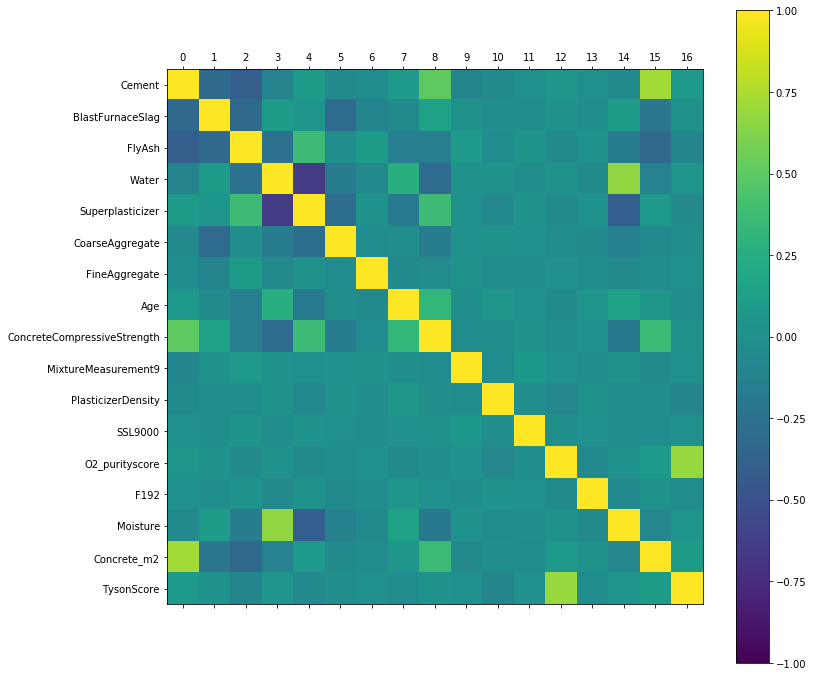

In [9]:
feature_names = list(train_data)  # CORRELATIONPLOT
correlations = train_data.corr()
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0, 17, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_yticklabels(feature_names)
plt.show()

In [10]:
# =============================================================================
# Remove outliers and seperate target from features.
# =============================================================================
Q1 = train_data.quantile(0.25)
Q3 = train_data.quantile(0.75)
IQR = Q3-Q1
print("Observations BEFORE removing outliers:", train_data.shape[0])
X = train_data[~((train_data < (Q1 - 1.5 * IQR)) |(train_data > (Q3 + 1.5 * IQR))).any(axis=1)]
X = X.values
X_test = test_data.values
y = X[:, 8]
X = np.delete(X, 8, 1)
print("Observations AFTER removing outliers:", X.shape[0])

Observations BEFORE removing outliers: 723
Observations AFTER removing outliers: 598


In [11]:
# =============================================================================
# Find feature importance using DecisionTreeRegressor and transform data
# =============================================================================
regr = DecisionTreeRegressor(criterion="mae", random_state=0)
selector = SelectFromModel(regr)
selector.fit(X, y)
X = selector.transform(X)
X_test = selector.transform(X_test)

In [12]:
# =============================================================================
# Print out the features that were kept by the DecisionTreeRegressor
# =============================================================================
filt = selector.get_support()
column_names = list(test_data)
chosen_columns = list(compress(column_names, filt))
chosen_columns

['Cement', 'BlastFurnaceSlag', 'Water', 'Age']

In [13]:
# =============================================================================
# Using GridSearchCV to find optimal hyperparameters for GradientBoostingRegressor
# =============================================================================
regr = GradientBoostingRegressor()
parameters = {"learning_rate":[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
              "n_estimators":[100, 500, 1000, 2000, 5000, 10000]}
search = GridSearchCV(regr, param_grid=parameters, scoring="neg_mean_absolute_error",
                      cv=5, n_jobs=-1)
search.fit(X, y)

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3], 'n_estimators': [100, 500, 1000, 2000, 5000, 10000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_absolute_error', verbose=0)

In [14]:
# =============================================================================
# Show best score and the chosen hyperparameters 
# =============================================================================
print("Best score:",abs(search.best_score_))
print("Best parameters:",search.best_params_)

Best score: 3.5501294280252553
Best parameters: {'learning_rate': 0.2, 'n_estimators': 1000}


In [15]:
# =============================================================================
# Predict test data using best parameters
# =============================================================================
y_test_pred = search.predict(X_test)

In [16]:
# =============================================================================
# Create the csv file for upload to kaggle
# =============================================================================
dfscore = pd.DataFrame(y_test_pred)
ID = np.arange(0, 309, dtype=np.int64)
dfID = pd.DataFrame(ID)
dfscore.columns = ["ConcreteCompressiveStrength"]
dfID.columns = ["Id"]
final_df = pd.concat([dfID, dfscore], axis=1)
final_df.to_csv("Comp3_Julius_Kviman_ver4.csv", sep=",", index=False)